# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

# Load data 

In [2]:
# get data from data folder
df_og = pd.read_csv('../data/Real_es.csv')
df = df_og.copy()

# Cleaning the data

## We check Qualitatif and Quantitatif attributs

In [3]:
# get the columns with type object 
object_columns = df.select_dtypes(include=['object']).columns
# get the columns with type non object
non_object_columns = df.select_dtypes(exclude=['object']).columns
print("Qualitatif Columns : ", object_columns.size , "->", object_columns)
print("\nQuantitatif Columns : ", non_object_columns.size, "->", non_object_columns)


Qualitatif Columns :  15 -> Index(['Type of property', 'Price', 'Status', 'Customer ID', 'Entity', 'Name',
       'Surname', 'Age at time of purchase', 'Interval', 'Gender', 'Country',
       'State', 'Purpose', 'Mortgage', 'Source'],
      dtype='object')

Quantitatif Columns :  10 -> Index(['ID', 'Building', 'Year of sale', 'Month of sale', 'Property #',
       'Area (ft.)', 'Y', 'M', 'D', 'Deal satisfaction'],
      dtype='object')


### **Note :** 
We can note that some columns are meant to be quantitatif but they're qualitatif (Price, Age at time of purchase)

In [4]:
df.iloc[0]

ID                                  1030
Building                               1
Year of sale                      2005.0
Month of sale                       11.0
Type of property               Apartment
Property #                            30
Area (ft.)                        743.09
Price                       $246,172.68 
Status                             Sold 
Customer ID                        C0028
Entity                        Individual
Name                             Madalyn
Surname                           Mercer
Age at time of purchase               19
Interval                           18-25
Y                                 1986.0
M                                    6.0
D                                   21.0
Gender                                 F
Country                              USA
State                         California
Purpose                             Home
Deal satisfaction                    5.0
Mortgage                              No
Source          

In [5]:
print(df['Price'].dtype)
print(df['Age at time of purchase'].dtype)

object
object


### **Note :**
We can note that price and age at time of purchase arent float (we may need them for a future modeling)

## Cleaning the data
* *Fix the type of both* **Price** and **Age at time of purchase**
* *Handle missing values* : for *qualitatif data* -> replace the missing data with the mode of that column (most repeated value), 
                                *quantitatif data* -> replace the missing data with the mean
* *Remove unecessary columns* : the columns whom contains 1 value only and the columns whom contain id in their name and we use capitalize
* *Drop duplicated lines*

In [6]:
print("----Before cleaning----")
print("The shape of the data set :",df.shape)
print("The number of empty cases in each column :")
print(df.isnull().sum())

----Before cleaning----
The shape of the data set : (196, 25)
The number of empty cases in each column :
ID                          0
Building                    0
Year of sale                1
Month of sale               1
Type of property            0
Property #                  0
Area (ft.)                  0
Price                       0
Status                      1
Customer ID                 1
Entity                      1
Name                        1
Surname                     1
Age at time of purchase    17
Interval                   18
Y                          18
M                          18
D                          18
Gender                     18
Country                     1
State                      15
Purpose                     1
Deal satisfaction           1
Mortgage                    1
Source                      1
dtype: int64


In [7]:
# handle price
def clean_price(df):
    # handle the price => removing the $ and remove empy spaces and make it float
    df['Price'] = df['Price'].str.replace(' ', '')
    df['Price'] = df['Price'].str.replace(',', '')
    df['Price'] = df['Price'].str.replace('$', '')
    df['Price'] = df['Price'].astype(float)
    
    # handle the outliers
    # we will use the IQT method
    # get the first and third quartile
    q1 = df['Price'].quantile(0.25)
    q3 = df['Price'].quantile(0.75)
    iqt = q3 - q1
    # remove the outliers
    df = df[(df['Price'] >= q1 - 1.5*iqt) & (df['Price'] <= q3 + 1.5*iqt)]

    # normalize the price
    df['Price'] = (df['Price'] - df['Price'].min()) / (df['Price'].max() - df['Price'].min())
    
    return df

# handle Age at time of purchase -> make it int
def clean_age(df):
    # if the case of df['Age at time of purchase'] is empty we make nan int
    # and then we fill the nan with the mean of the column
    df['Age at time of purchase'] = df['Age at time of purchase'].replace(' ', np.nan)
    df['Age at time of purchase'] = df['Age at time of purchase'].astype(float)
    return df

def handle_categorical_data(column):
    if column.dtype == "object":
        return column.astype('category').cat.codes
    
    return column

def handle_missing_values(column):
    # most repetitive value for categorical columns
    if column.dtype == "object":
        return column.fillna(column.mode()[0])
    # mean value for numerical columns
    else:
        return column.fillna(column.mean())
    
def clean_data(df):
    # handle Age at time of purchase
    df = clean_age(df)

    # handle the price => make the column float and handler the outliers of this columns
    # it is clear that price column is the only column that may have outliers
    df = clean_price(df)
    df = df.apply(handle_missing_values, axis=0)

    # remove unecessary columns
    # the columns whom contains 1 value only and the columns whom contain id in their name and we use capitalize
    df = df.drop(columns=df.columns[df.nunique() == 1])
    df = df.drop(columns=df.columns[df.columns.str.contains('id', case=False)])

    df = df.apply(handle_categorical_data, axis=0)

    # drop duplicated lines
    df = df.drop_duplicates()

    return df


In [8]:
df = clean_data(df_og.copy())
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_11840\4161591911.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = (df['Price'] - df['Price'].min()) / (df['Price'].max() - df['Price'].min())


,Building,Year of sale,Month of sale,Type of property,Property #,Area (ft.),Price,Entity,Name,Surname,...,Y,M,D,Gender,Country,State,Purpose,Deal satisfaction,Mortgage,Source
0,1,2005.0,11.0,0,30,743.09,0.378979,1,102,89,...,1986.0,6.0,21.0,0,7,1,0,5.0,0,2
1,1,2005.0,10.0,0,29,756.21,0.379448,1,95,16,...,1983.0,2.0,24.0,0,7,1,0,5.0,0,2
2,2,2007.0,7.0,0,2,587.28,0.270268,1,39,38,...,1985.0,12.0,27.0,1,7,1,0,1.0,1,1
3,2,2007.0,12.0,0,31,1604.75,0.987469,1,33,28,...,1985.0,12.0,27.0,1,7,1,1,3.0,1,2
5,3,2007.0,9.0,0,11,675.19,0.253209,1,81,107,...,1981.0,12.0,26.0,0,7,7,1,5.0,0,1


In [9]:
print("----Before cleaning----")
print("The shape of the data set :",df.shape)
print("The number of empty cases in each column :")
print(df.isnull().sum())

----Before cleaning----
The shape of the data set : (186, 22)
The number of empty cases in each column :
Building                   0
Year of sale               0
Month of sale              0
Type of property           0
Property #                 0
Area (ft.)                 0
Price                      0
Entity                     0
Name                       0
Surname                    0
Age at time of purchase    0
Interval                   0
Y                          0
M                          0
D                          0
Gender                     0
Country                    0
State                      0
Purpose                    0
Deal satisfaction          0
Mortgage                   0
Source                     0
dtype: int64


# Visualisation
To get the relation between the attributs, we'll use the correlation matrix fist. Then, we'll study each relation we conclude

## Correlation Matrix

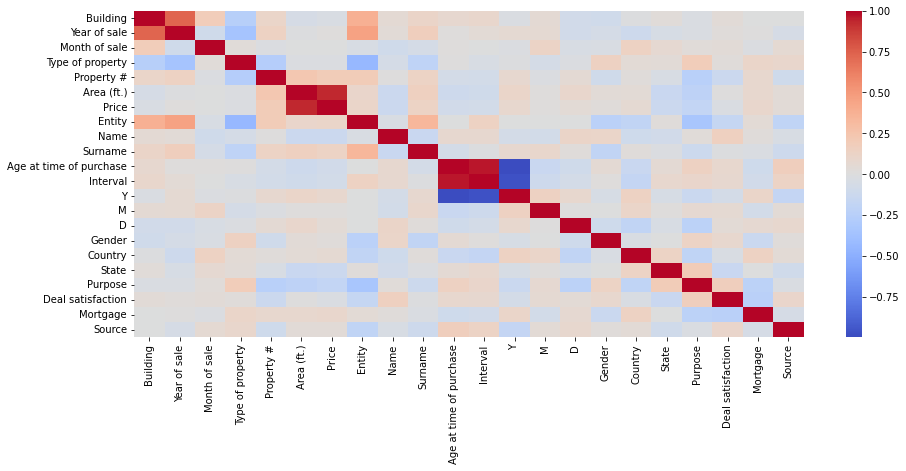

In [10]:
# correlation matrix
corr = df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

We can note that there's a relation between :

* **Price** and **Area** : <span style="color:red;">Positive correlation</span> which is logical as the area of the appartment is the main feature to choose its price
* **Price** and **Property #** : <span style="color:red;">Positive correlation</span>
* **Entity** and **Type pf property** : <span style="color:blue;">Negative correlation</span>
* **Entity** and **Year of sale** : <span style="color:red;">Positive correlation</span>
* **Entity** and **Purpose** : <span style="color:blue;">Negative correlation</span>
* **Entity** and **Building** : <span style="color:red;">Positive correlation</span>
* **Age at time of purchase** and **Interval** : <span style="color:red;">Positive correlation</span> in this case we can say that the data are mostly correct and dont need a verification
* **Age at time of purchase** and **Y** : <span style="color:blue;">Negative correlation</span>

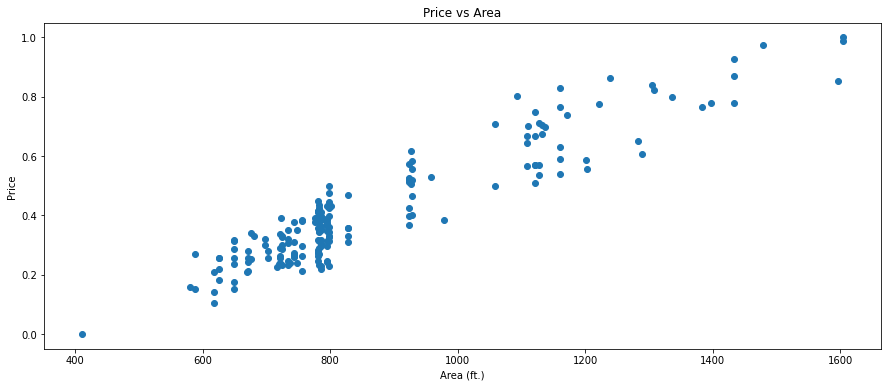

In [11]:
# plot the price and the area 
plt.figure(figsize=(15,6))
plt.scatter(df['Area (ft.)'], df['Price'])
plt.xlabel('Area (ft.)')
plt.ylabel('Price')
plt.title('Price vs Area')
plt.show()


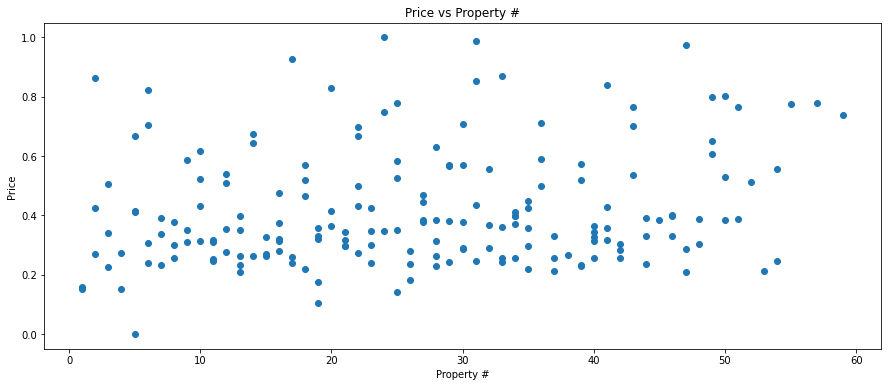

In [12]:
# plot the price and the area 
plt.figure(figsize=(15,6))
plt.scatter(df['Property #'], df['Price'])
plt.xlabel('Property #')
plt.ylabel('Price')
plt.title('Price vs Property #')
plt.show()

c:\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


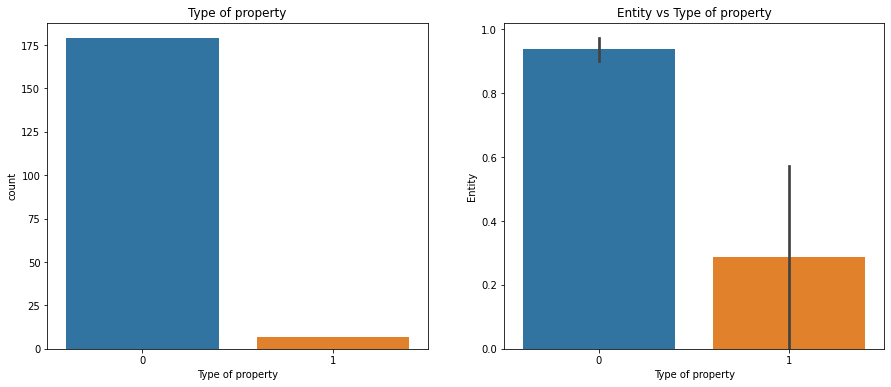

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.countplot(df['Type of property'])
plt.title('Type of property')
plt.subplot(122)
sns.barplot(x='Type of property', y='Entity', data=df)
plt.title('Entity vs Type of property')
plt.show()

c:\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


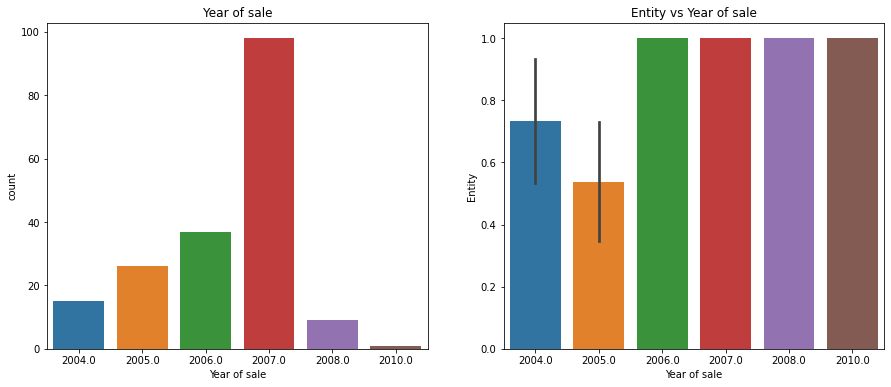

In [14]:
# plot the price according to the year of sale
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.countplot(df['Year of sale'])
plt.title('Year of sale')
plt.subplot(122)
sns.barplot(x='Year of sale', y='Entity', data=df)
plt.title('Entity vs Year of sale')
plt.show()

c:\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


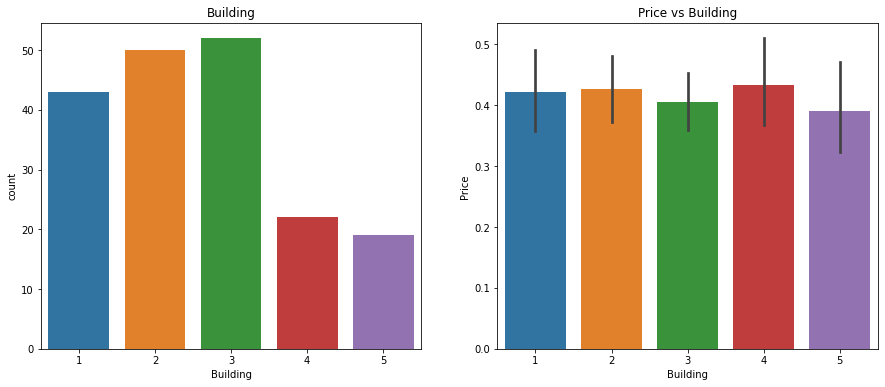

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.countplot(df['Building'])
plt.title('Building')
plt.subplot(122)
sns.barplot(x='Building', y='Price', data=df)
plt.title('Price vs Building')
plt.show()

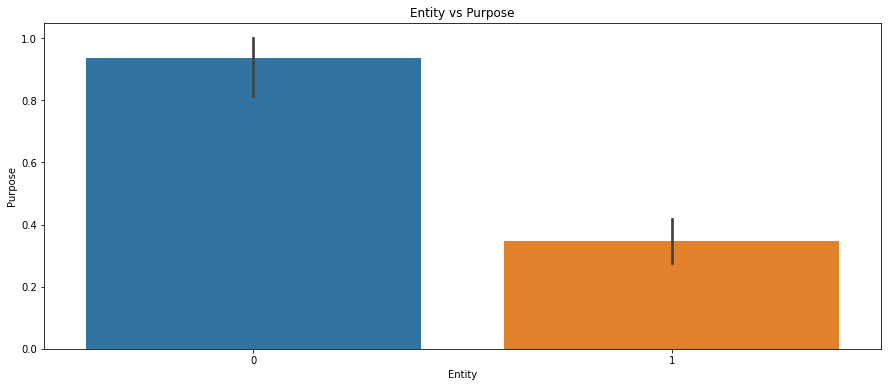

In [16]:
plt.figure(figsize=(15,6))
sns.barplot(x='Entity', y='Purpose', data=df)
plt.title('Entity vs Purpose')
plt.show()

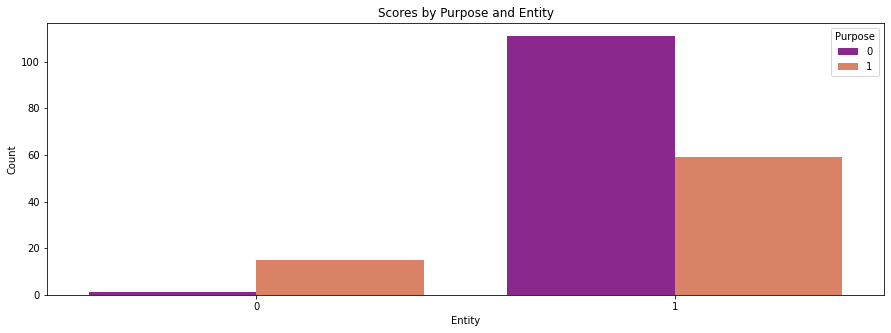

In [17]:
fig, axes = plt.subplots( figsize=(15, 5), sharey=True)
sns.countplot(ax=axes,x="Entity",hue="Purpose", data=df, palette='plasma')
axes.set_title(f'Scores by Purpose and Entity')
axes.set_xlabel("Entity")
axes.set_ylabel('Count')
plt.show()

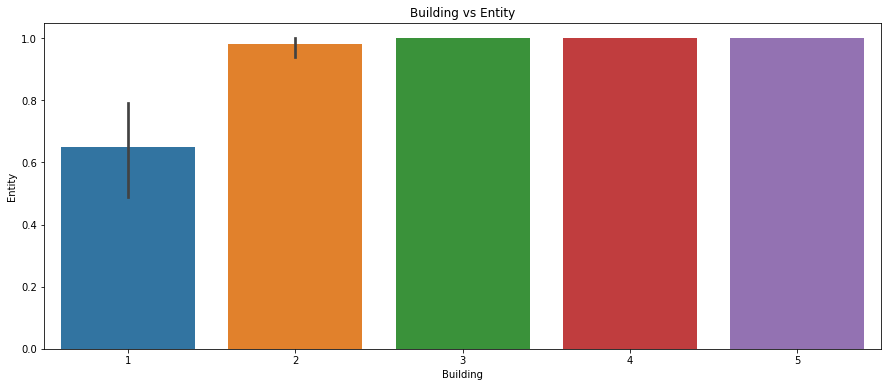

In [18]:
plt.figure(figsize=(15,6))
sns.barplot(x='Building', y='Entity', data=df)
plt.title('Building vs Entity')
plt.show()

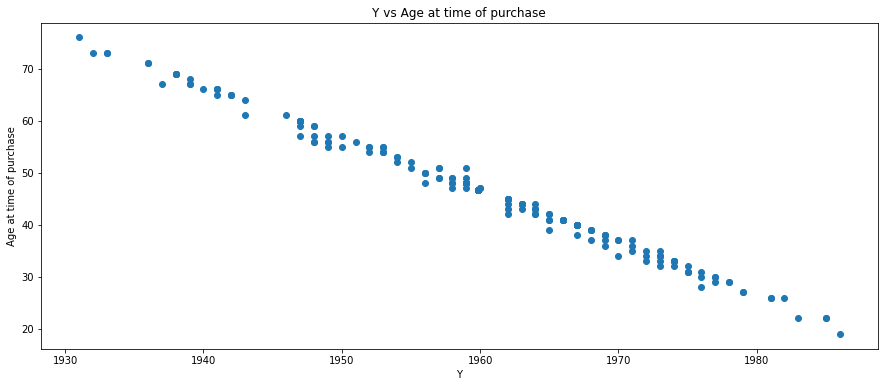

In [19]:
# plot the price and the area 
plt.figure(figsize=(15,6))
plt.scatter(df['Y'], df['Age at time of purchase'])
plt.xlabel('Y')
plt.ylabel('Age at time of purchase')
plt.title('Y vs Age at time of purchase')
plt.show()

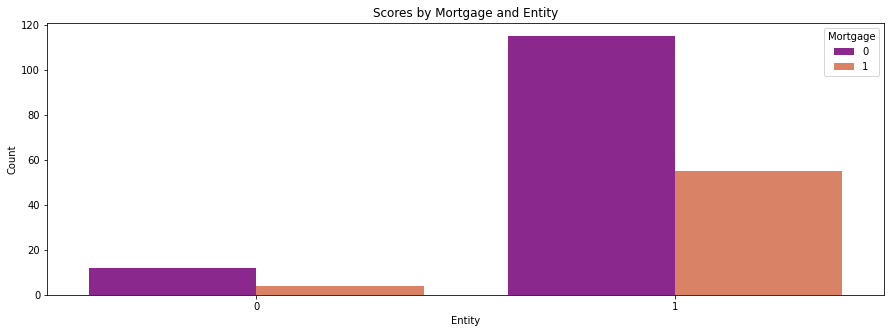

In [20]:
fig, axes = plt.subplots( figsize=(15, 5), sharey=True)
sns.countplot(ax=axes,x="Entity",hue="Mortgage", data=df, palette='plasma')
axes.set_title(f'Scores by Mortgage and Entity')
axes.set_xlabel("Entity")
axes.set_ylabel('Count')
plt.show()

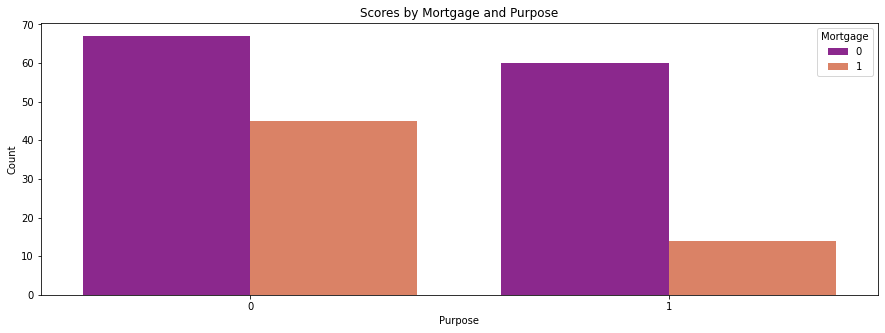

In [21]:
fig, axes = plt.subplots( figsize=(15, 5), sharey=True)
sns.countplot(ax=axes,x="Purpose",hue="Mortgage", data=df, palette='plasma')
axes.set_title(f'Scores by Mortgage and Purpose')
axes.set_xlabel("Purpose")
axes.set_ylabel('Count')
plt.show()

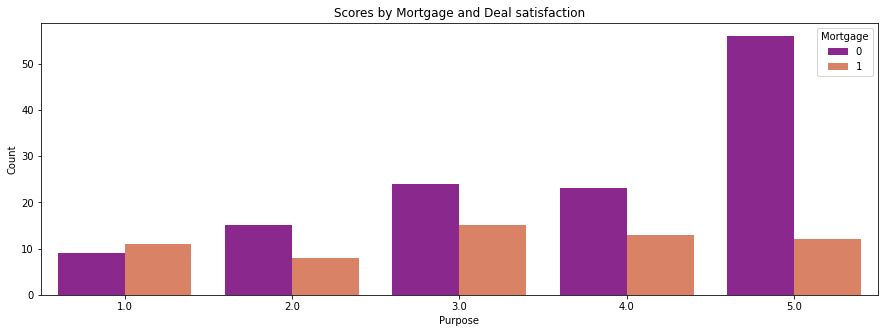

In [22]:
fig, axes = plt.subplots( figsize=(15, 5), sharey=True)
sns.countplot(ax=axes,x="Deal satisfaction",hue="Mortgage", data=df, palette='plasma')
axes.set_title(f'Scores by Mortgage and Deal satisfaction')
axes.set_xlabel("Purpose")
axes.set_ylabel('Count')
plt.show()

### **Note**
We can say that our analysis above is correct according to the chart we had.

* We can also train a classification model to get if the person has mortgage or no 
* Or to predict the purpose of the appartment


# Machine Learning

## Predict the mortgage

c:\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


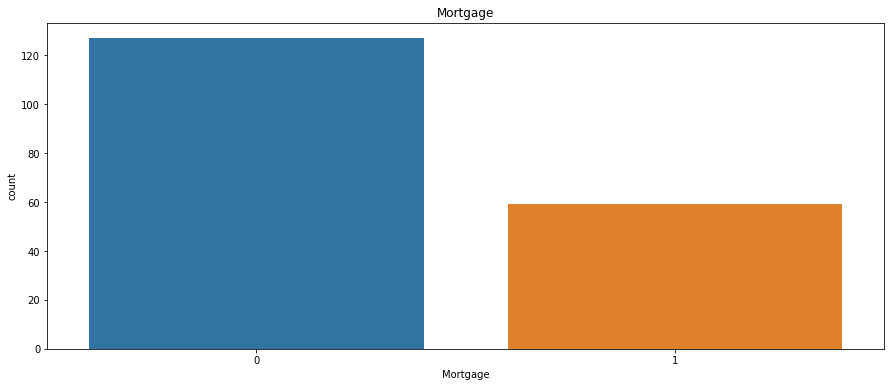

In [23]:
# histograme of mortgage
plt.figure(figsize=(15,6))
sns.countplot(df['Mortgage'])
plt.title('Mortgage')
plt.show()

#### **Note :**
We can note that the mortgage data is unbalanced

### Split the data

In [48]:
target = 'Mortgage'
X = df.drop(target, axis=1)
y = df[target]
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
# save them in a csv 
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

### Define the functions of training and evaluation

In [49]:
def train_predict(model):
    # Train the model
    model.fit(X_train, y_train)
    # Save the model
    pickle.dump(model, open(f'../saved_models/{model.__class__.__name__}.pkl','wb'))
    # Predict the model
    y_pred = model.predict(X_test)
    return y_pred

def evaluate_model(y_pred):
    # Evaluate the model
    print('Accuracy Score :', metrics.accuracy_score(y_test, y_pred))
    print('Precision Score :', metrics.precision_score(y_test, y_pred))
    print('Recall Score :', metrics.recall_score(y_test, y_pred))
    print('F1 Score :', metrics.f1_score(y_test, y_pred))
    print('ROC AUC Score :', metrics.roc_auc_score(y_test, y_pred))

### Define the models and their hyperparameters

In [50]:
logistic_regression = LogisticRegression(random_state=16, class_weight='balanced')


# Create a random forest classifier
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(class_weight='balanced')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
random_forest = RandomForestClassifier()

models = [logistic_regression, random_forest]

### Train the models

In [51]:
y_preds = {}

for model in models:
    y_pred = train_predict(model)
    y_preds[model.__class__.__name__] = y_pred

c:\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluation the models

In [52]:
# load models
logistic_regression = pickle.load(open('../saved_models/LogisticRegression.pkl','rb'))
random_forest = pickle.load(open('../saved_models/RandomForestClassifier.pkl','rb'))

In [53]:
# make prediction with X_test
y_pred_logistic_regression = logistic_regression.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)
# convert to probability distribution
y_pred_logistic_regression_proba = logistic_regression.predict_proba(X_test)
y_pred_random_forest_proba = random_forest.predict_proba(X_test)

# make y_preds
y_preds = {
    'LogisticRegression': y_pred_logistic_regression,
    'RandomForestClassifier': y_pred_random_forest
}


In [54]:
for name, y_pred in y_preds.items():
    print(f'Evaluation for {name}')
    evaluate_model(y_pred)
    print('-------------------------------------------------------')

Evaluation for LogisticRegression
Accuracy Score : 0.6071428571428571
Precision Score : 0.43478260869565216
Recall Score : 0.5263157894736842
F1 Score : 0.47619047619047616
ROC AUC Score : 0.5874822190611664
-------------------------------------------------------
Evaluation for RandomForestClassifier
Accuracy Score : 0.6071428571428571
Precision Score : 0.2857142857142857
Recall Score : 0.10526315789473684
F1 Score : 0.15384615384615385
ROC AUC Score : 0.4850640113798008
-------------------------------------------------------


### Show the confusion matrix

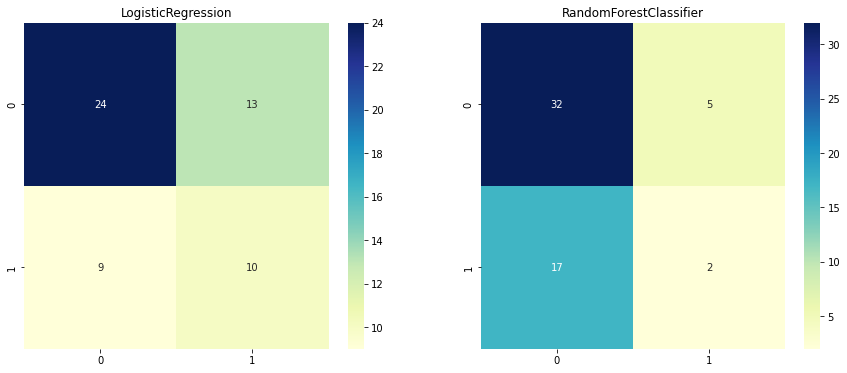

In [55]:
# plot confusion matrix
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.heatmap(metrics.confusion_matrix(y_test, y_preds['LogisticRegression']), annot=True, cmap='YlGnBu')
plt.title('LogisticRegression')
plt.subplot(122)
sns.heatmap(metrics.confusion_matrix(y_test, y_preds['RandomForestClassifier']), annot=True, cmap='YlGnBu')
plt.title('RandomForestClassifier')
plt.show()

### Show the ROC curve

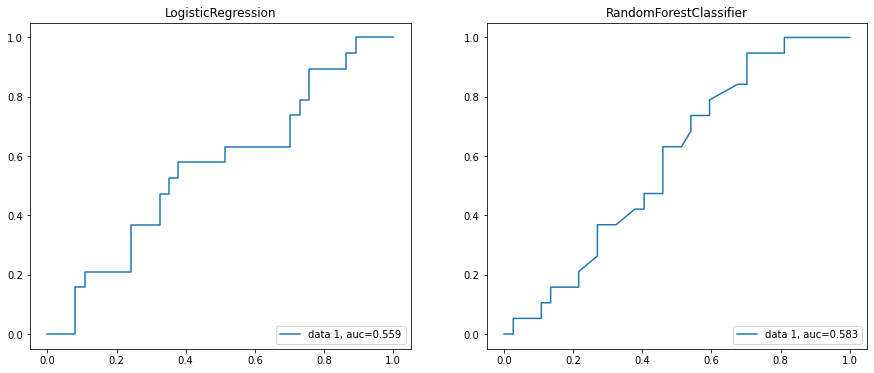

In [56]:
def plot_roc_curve(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label=f"data 1, auc={auc:.3f}")

plt.figure(figsize=(15,6))

plt.subplot(121)
plot_roc_curve(logistic_regression, X_test, y_test)
plt.legend(loc=4)
plt.title('LogisticRegression')

plt.subplot(122)
plot_roc_curve(random_forest, X_test, y_test)
plt.legend(loc=4)
plt.title('RandomForestClassifier')
plt.show()

# Conclusion
Both models didnt get a good prediction, hoever we must mention that the data is unbalanced
We can note that random forest is better than logistic regression for multiple reasons, we metion : 
* Non linearity between data 
* The relation between the attribute could be better captured using random forest 